In [3]:
from pymacy.db import get_db
from pymacy.learning.volume_predictor import ConditionalVolumePredictor
from matminer.learners.volume_predictor import VolumePredictor
from pymatgen import Structure, Specie
from pymatgen.util.plotting_utils import get_publication_quality_plot
import itertools
import numpy as np
import scipy as sp
import seaborn as sns
import os
import warnings

%matplotlib inline

db = get_db(admin=True)
proto = db.icsd_2016_v2_prototypes

In [10]:
def plot_error(errors):
    bins = np.arange(0, 10, 0.1)
    plt = get_publication_quality_plot(12, 8)
    sns.distplot(errors, bins=bins, kde=False, rug=True)
    plt.xlabel("Error")
    plt.ylabel("Number")
    plt.xlim((0, 5))
    print("Mean error = %.2f, median error = %.2f, max error=%.2f, std dev. = %.2f, MAE = %.2f" % 
          (np.mean(errors), np.median(errors), np.max(errors), np.std(errors), 
           np.mean(np.absolute(errors))))
    
def plot_vol_data(vol_data, xlim=100, ylim=1):
    x_values = np.array([e[0] for e in vol_data])
    y_values = np.array([e[1] for e in vol_data])

    one_factor_slope = np.sum(y_values * x_values) / np.sum(x_values * x_values)
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x_values, y_values)
    print("OLS")
    print("---")
    print("Slope = %.2f" % slope)
    print("Intercept = %.2f" % intercept)
    print("r = %f" % r_value)
    print("std_err = %f" % std_err)
    mse = np.sqrt(np.average((y_values - x_values * slope - intercept) ** 2))
    print("MSE = %.2f" % mse)
    print("")
    print("One factor LS (fit to y = mx, with intercept forced to be zero)")
    print("-------------")
    print("One factor Slope = %.2f" % one_factor_slope)
    one_factor_rmse = np.sqrt(np.average((y_values - one_factor_slope * x_values) ** 2))
    print("One factor RMSE = %f" % one_factor_rmse)
    print("Min, max, actual vol ratios = %f %f" % (min(y_values), max(y_values)))

    plt = get_publication_quality_plot(12,8)
    plt.plot(x_values, y_values, 'x', markeredgewidth=2)
    plt.plot(np.arange(0,100),np.arange(0,100), "k--")
    plt.xlabel("Predicted ratio")
    plt.ylabel("Actual Volume ratio")
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    
    return plt
    
def plot_data(data, xlim=100, ylim=10, xlabel="x", ylabel="y"):
    x_values = np.array([e[0] for e in data])
    y_values = np.array([e[1] for e in data])
    
    plt = get_publication_quality_plot(12,8)
    plt.plot(x_values, y_values, 'x', markeredgewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    
    return plt

In [5]:
nprototypes = 100
num_structs = 20

def get_cvp_data(all_data, nprototypes, num_structs, is_ionic_radius=True, 
                   iso_only=False):
    
    cvp = ConditionalVolumePredictor()
    cvp_errors = []
    vol_data = []
    matched_structures = []

    for i, d in enumerate(all_data):
        if i > nprototypes:
            break

        reduced_matches = d["matches"][:num_structs]
        
        for d1, d2 in itertools.combinations(reduced_matches, 2): 
        
            with warnings.catch_warnings():
                # Avoid printing of warnings messages that contribute to
                # visual noise.
                warnings.simplefilter("ignore")
        
                try:
                    s1 = Structure.from_dict(d1["structure"])
                    s2 = Structure.from_dict(d2["structure"])
                    
                    if s1.volume > s2.volume:
                        s1, s2 = s2, s1
                
                    valid_mapping = True
                    oxi_diff = False
            
                    for k, v in d1["mapping"]:
                        sp1 = Specie.from_string(v)
                        sp2 = Specie.from_string(dict(d2["mapping"])[k])
                    
                        if sp1.oxi_state * sp2.oxi_state < 0:
                            valid_mapping = False
                            break
                        
                        if iso_only and abs(sp1.oxi_state - sp2.oxi_state) > 1e-8:
                            valid_mapping = False
                            break
                          
                        if not oxi_diff and abs(sp1.oxi_state - sp2.oxi_state) > 1e-8:
                            oxi_diff = True
            
                    if not valid_mapping:
                        continue
            
                    new_vol = cvp.predict(s1, s2, test_isostructural=False, 
                                          is_ionic_radius=is_ionic_radius)
                
                    ratio = new_vol / s2.volume
                    vol_data.append([ratio, s1.volume/s2.volume])
                
                    cvp_errors.append(abs(new_vol / s1.volume - 1.0))
                    matched_structures.append((s1, s2, d1["icsd_ids"][0], 
                                               d2["icsd_ids"][0], oxi_diff, i))
        
                except Exception as ex:
                    pass
                
    print("Done with %d CVP predictions." % len(cvp_errors))
    print("The length of vol data is %d." % len(vol_data))
    
    return cvp_errors, matched_structures, vol_data
    

In [6]:
# We will limit ourselves to binaries and ternaries for now.
# nmatches >= 25 selects only prototypes with more than one structure.

#criteria = {"nelements": {"$gte": 2}, "nmatches": {"$gte": 25}}
#anions = set(["O", "S", "Se", "F", "Cl", "Br", "I", "N"])

def get_all_data(criteria, anions):
    
    all_data = []
    
    def is_close(a, b, tol=1e-8):
        return abs(a-b) < tol

    for r in proto.find(criteria, projection=["matches", "nmatches", 
                                               "parent_formula", 
                                               "parent_spacegroup"]):
        sub_data = {}
        sub_data.update({k:v for k, v in r.items() if k != "matches"})
        sub_data["matches"] = []
    
        for d in r["matches"]:
            s = Structure.from_dict(d["structure"])
            symbols = [e.symbol for e in list(s.composition.keys())]
        
            if any([e.Z > 83 or 57 < e.Z < 72 for e in list(s.composition.keys())]):
                continue
        
            # Need oxidation states to be assigned beforehand
            if any([is_close(e.oxi_state, 0.0) for e in list(s.composition.keys())]):
                continue
        
            # Exclude fractional oxidation states
            if any([(e.oxi_state % 1) > 1e-8 for e in list(s.composition.keys())]):
                continue
        
            if set(symbols).intersection(anions) != set():
                sub_data["matches"].append(d)
            
        if len(sub_data["matches"]) > 1:
            all_data.append(sub_data)

    #Sorted list
    all_data = sorted(all_data, key=lambda e: e["nmatches"], reverse=True)
    
    return all_data

In [7]:
criteria = {"nelements": {"$gte": 2}, "nmatches": {"$gte": 25}}
anions = set(["O", "S", "Se", "F", "Cl", "Br", "I", "N"])

all_data = get_all_data(criteria, anions)

all_formulas = []

print("There are %d prototypes." % len(all_data))

for i, d in enumerate(all_data):
    formulas = []
    for r in d["matches"]:
        s = Structure.from_dict(r["structure"])
        formulas.append(s.composition.reduced_formula)
    
    all_formulas.append(formulas)
    print(i, d["parent_formula"], d["parent_spacegroup"]["symbol"])

There are 110 prototypes.
0 Ba(AgGe)2 I4/mmm
1 BaBrCl Pnma
2 Ag3SI R3
3 AgI Pm-3m
4 AgBr Fm-3m
5 Ba2BiIrO6 P-1
6 AlCrCo2 Fm-3m
7 Ag3SBr Cmcm
8 BaAgAs P6_3/mmc
9 AcBrO P4/nmm
10 AgAsSe2 R-3m
11 BeAlB F-43m
12 Ce3AgGeS7 P6_3
13 Ba2CaUO6 P2_1/c
14 Ag2MoO4 Fd-3m
15 Ag2S P2_1/c
16 Am2Zr2O7 Fd-3m
17 Ba(DyS2)2 Pnma
18 AgC F-43m
19 BaAs2Pd Cmcm
20 Ba(AgS)2 P-3m1
21 Al3Ni Pnma
22 BaDyCuTe3 Cmcm
23 BaAgSF P4/nmm
24 Ca6Ge2O Fm-3m
25 AgCl Cmcm
26 BaU2Se5 Pnma
27 AgIO4 I4_1/a
28 AlCr2C P6_3/mmc
29 Al2Au Fm-3m
30 Ba7(ClF6)2 P-6
31 Al2Os I4/mmm
32 AgN P6_3/mmc
33 Am3Se4 I-43d
34 AgF2 Pbca
35 Ba2HfS4 I4/mmm
36 Ba2CoO4 Pnma
37 AmS2 P4/nmm
38 Am2O3 Ia3
39 AgSnF6 P-1
40 CaCrO4 I4_1/amd
41 AlCu3 Fm-3m
42 Ba3BiN P6_3/mmc
43 AlAgS2 I-42d
44 Ag2F P-3m1
45 CaCo4(CuO4)3 Im3
46 Ba(CrAs)2 I4/mmm
47 As2Os Pnnm
48 BaF2 P6_3/mmc
49 AsPdS P2_13
50 Al2Cd3(SiO4)3 Ia-3d
51 BaU2Te5 I4/mcm
52 AgHg3SbO6 R-3c
53 AcBr3 P6_3/m
54 Ba3BiIr2O9 C2/c
55 CaInBr3 Cmcm
56 AgBr P2_1/m
57 AlBiO3 R3c
58 BeAl2O4 Pnma
59 Dy3ReO7 C222_1
6

#  CVP-ionic scheme

In [8]:
nprototypes = 100
num_structs = 20

cvp_errors_i, matched_structures_i, vol_data_i = get_cvp_data(all_data, nprototypes, 
                                                        num_structs, is_ionic_radius=True, 
                                                        iso_only=False)

Done with 10385 CVP predictions.
The length of vol data is 10385.


OLS
---
Slope = 0.77
Intercept = 0.18
r = 0.859015
std_err = 0.004517
MSE = 0.10

One factor LS (fit to y = mx, with intercept forced to be zero)
-------------
One factor Slope = 0.98
One factor RMSE = 0.107401
Min, max, actual vol ratios = 0.055585 1.000000
Mean error = 0.10, median error = 0.06, max error=2.52, std dev. = 0.15, MAE = 0.10


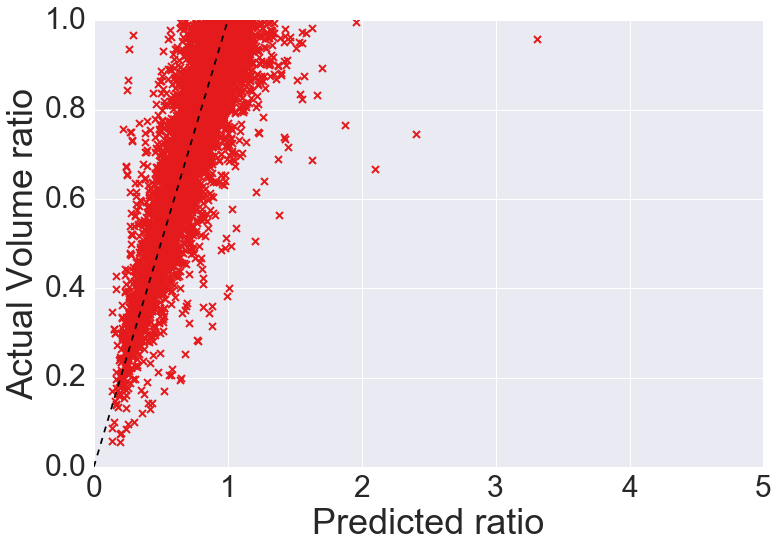

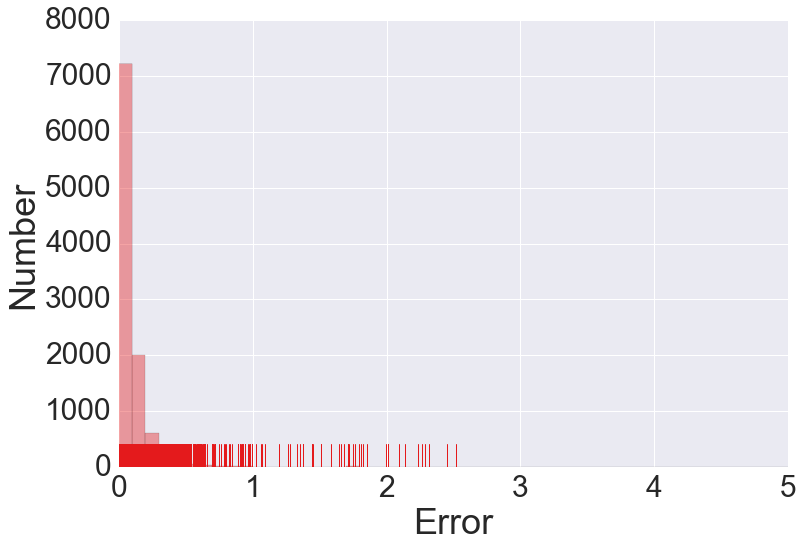

In [11]:
plot_vol_data(vol_data_i, xlim=5, ylim=1)
plot_error(cvp_errors_i)

# CVP-atomic scheme

In [13]:
nprototypes = 100
num_structs = 20

cvp_errors_a, matched_structures_a, vol_data_a = get_cvp_data(all_data, nprototypes, 
                                                        num_structs, is_ionic_radius=False, 
                                                        iso_only=False)

Done with 11536 CVP predictions.
The length of vol data is 11536.


OLS
---
Slope = 0.57
Intercept = 0.33
r = 0.715289
std_err = 0.005210
MSE = 0.14

One factor LS (fit to y = mx, with intercept forced to be zero)
-------------
One factor Slope = 0.95
One factor RMSE = 0.165425
Min, max, actual vol ratios = 0.055585 1.000000
Mean error = 0.16, median error = 0.09, max error=6.84, std dev. = 0.28, MAE = 0.16


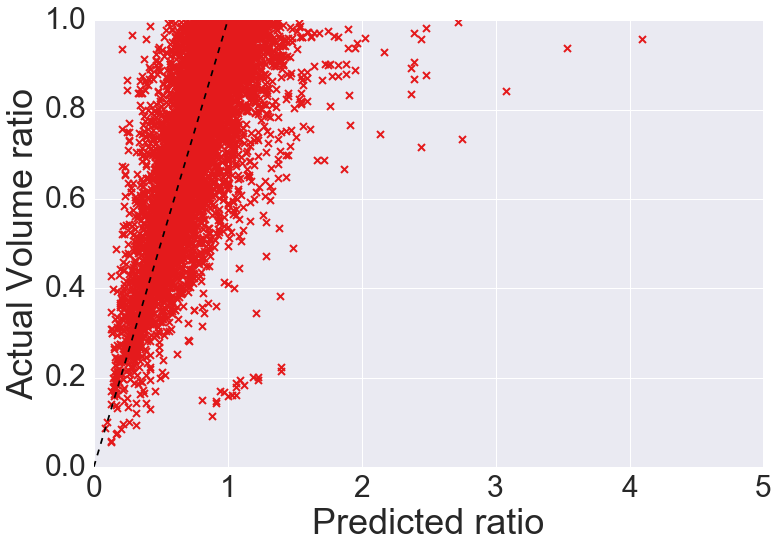

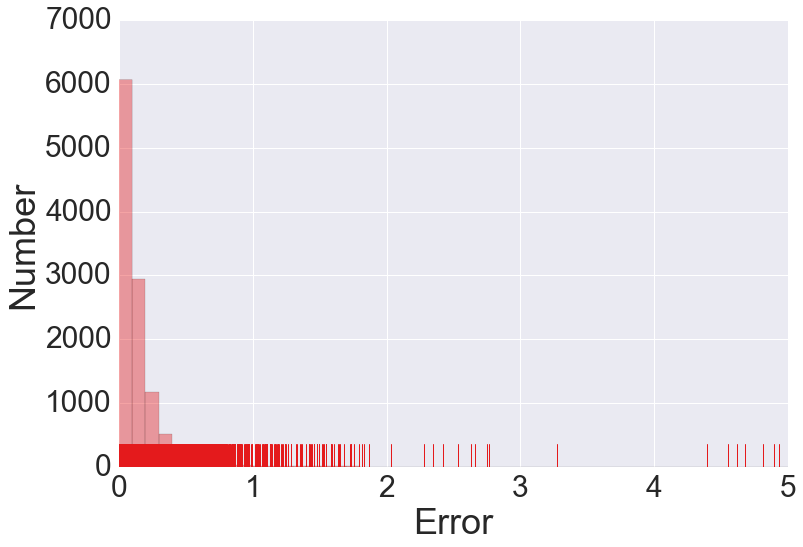

In [14]:
plot_vol_data(vol_data_a, xlim=5, ylim=1)
plot_error(cvp_errors_a)

# Check outliers

In [ ]:
from pymacy.learning.volume_predictor import ConditionalVolumePredictor

cvp = ConditionalVolumePredictor()
diff = 0
out = 0

for i, e in enumerate(cvp_errors_i):
    if e > 0.5:
        out += 1
        s1, s2, id1, id2, oxi_diff, index = matched_structures_i[i]
        s1_new = cvp.get_predicted_structure(s1, s2, test_isostructural=False, is_ionic_radius=True)
        if oxi_diff:
            diff += 1
        
        print("Error of %.2f predicting %s from %s in group %d" % (e, s1.composition.reduced_formula, 
                                                       s2.composition.reduced_formula, index))

print(diff, out)

In [ ]:
from pymacy.learning.volume_predictor import ConditionalVolumePredictor

cvp = ConditionalVolumePredictor()
diff = 0
out = 0

for i, e in enumerate(cvp_errors_a):
    if e > 0.5:
        out += 1
        s1, s2, id1, id2, oxi_diff, index = matched_structures_a[i]
        s1_new = cvp.get_predicted_structure(s1, s2, test_isostructural=False, is_ionic_radius=False)
        if oxi_diff:
            diff += 1
        
        print("Error of %.2f predicting %s from %s in group %d" % (e, s1.composition.reduced_formula, 
                                                       s2.composition.reduced_formula, index))

print(diff, out)

# Analyzes for number of elements

## Binary compounds

Done with 1513 CVP predictions.
The length of vol data is 1513.
OLS
---
Slope = 0.63
Intercept = 0.21
r = 0.781752
std_err = 0.012986
MSE = 0.15

One factor LS (fit to y = mx, with intercept forced to be zero)
-------------
One factor Slope = 0.90
One factor RMSE = 0.167653
Min, max, actual vol ratios = 0.055585 0.999377
Mean error = 0.20, median error = 0.11, max error=2.52, std dev. = 0.31, MAE = 0.20


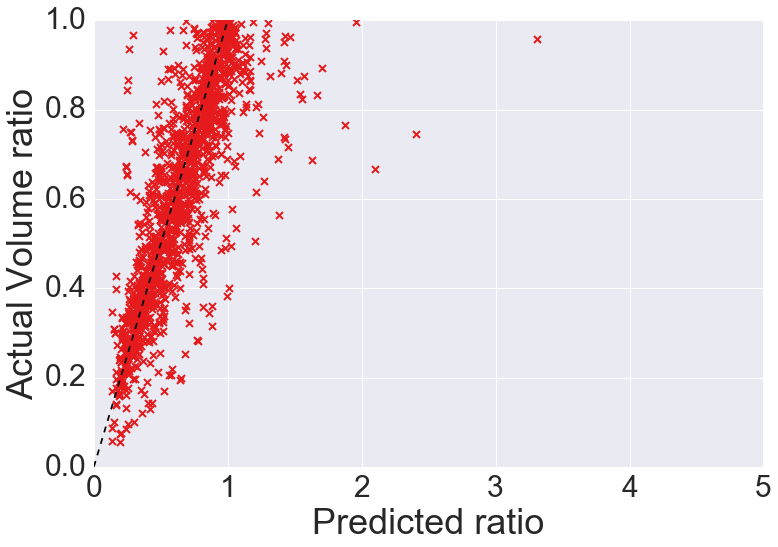

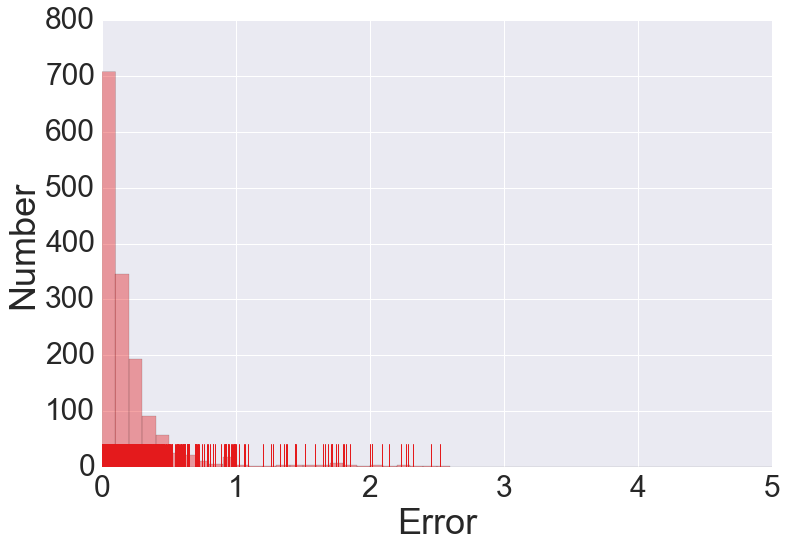

In [23]:
from pymatgen.core import Composition

nprototypes = 100
num_structs = 20
nelements = 2

sub_data = []

for i, d in enumerate(all_data):
    if i > nprototypes - 1:
        break
    comp = Composition(d["parent_formula"])
    if len(list(comp.keys())) == nelements:
        sub_data.append(d)
    
cvp_errors_i, matched_structures_i, vol_data_i = get_cvp_data(sub_data, nprototypes, 
                                                        num_structs, is_ionic_radius=True, 
                                                        iso_only=False)

plot_vol_data(vol_data_i, xlim=5, ylim=1)
plot_error(cvp_errors_i)

In [24]:
len(cvp_errors_i)

1513

## Ternary compounds

Done with 5841 CVP predictions.
The length of vol data is 5841.
OLS
---
Slope = 0.78
Intercept = 0.18
r = 0.874520
std_err = 0.005625
MSE = 0.09

One factor LS (fit to y = mx, with intercept forced to be zero)
-------------
One factor Slope = 0.98
One factor RMSE = 0.097071
Min, max, actual vol ratios = 0.132934 1.000000
Mean error = 0.09, median error = 0.06, max error=0.90, std dev. = 0.10, MAE = 0.09


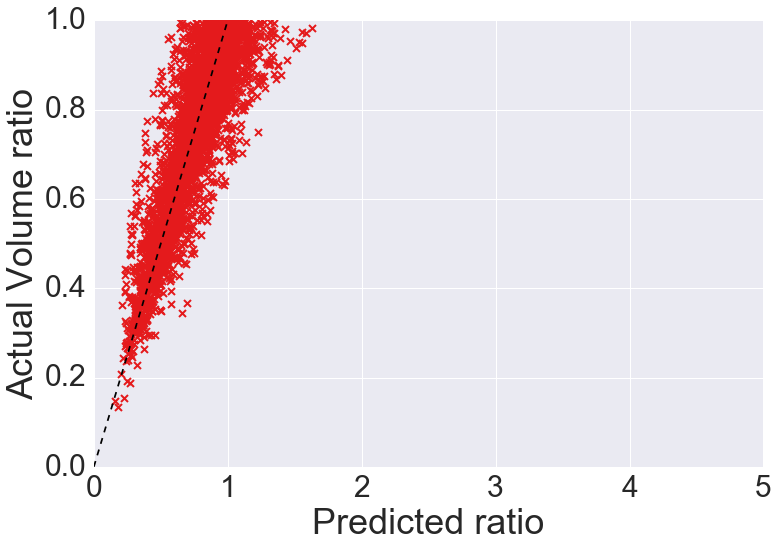

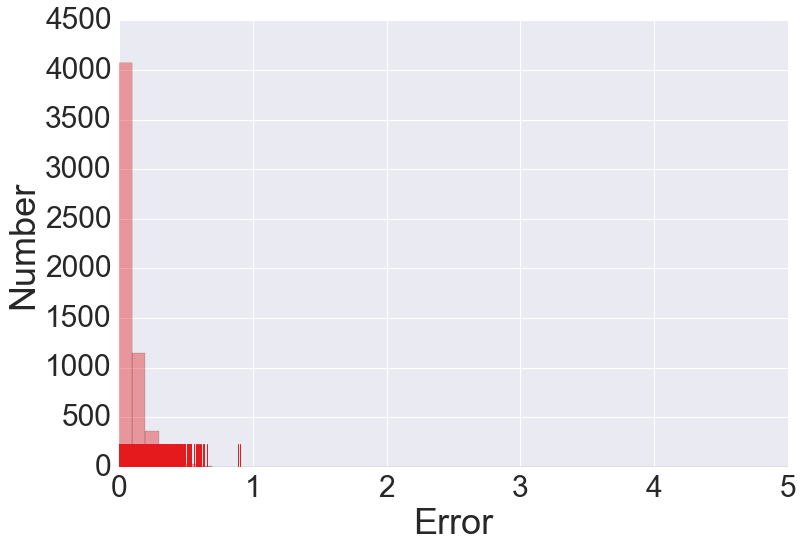

In [25]:
from pymatgen.core import Composition

nprototypes = 100
num_structs = 20
nelements = 3

sub_data = []

for i, d in enumerate(all_data):
    if i > nprototypes - 1:
        break
        
    comp = Composition(d["parent_formula"])
    if len(list(comp.keys())) == nelements:
        sub_data.append(d)
    

cvp_errors_i, matched_structures_i, vol_data_i = get_cvp_data(sub_data, nprototypes, 
                                                        num_structs, is_ionic_radius=True, 
                                                        iso_only=False)

plot_vol_data(vol_data_i, xlim=5, ylim=1)
plot_error(cvp_errors_i)

## More than 3 elements

Done with 2841 CVP predictions.
The length of vol data is 2841.
OLS
---
Slope = 0.71
Intercept = 0.27
r = 0.867657
std_err = 0.007607
MSE = 0.06

One factor LS (fit to y = mx, with intercept forced to be zero)
-------------
One factor Slope = 1.01
One factor RMSE = 0.069920
Min, max, actual vol ratios = 0.374738 1.000000
Mean error = 0.06, median error = 0.05, max error=0.38, std dev. = 0.06, MAE = 0.06


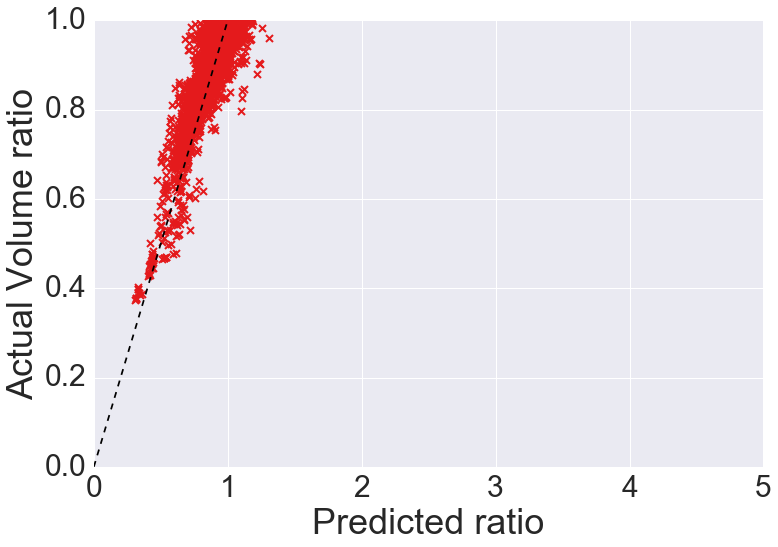

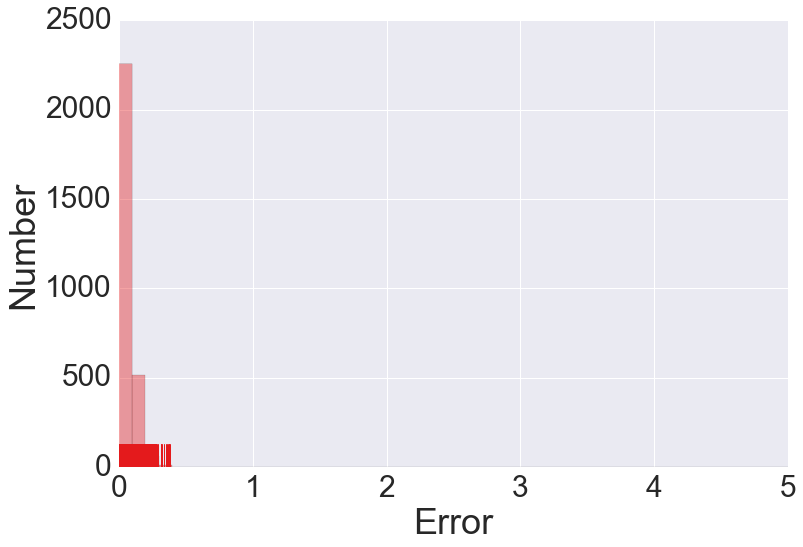

In [26]:
from pymatgen.core import Composition

nprototypes = 100
num_structs = 20
nelements = 3

sub_data = []

for i, d in enumerate(all_data):
    if i > nprototypes - 1:
        break
        
    comp = Composition(d["parent_formula"])
    if len(list(comp.keys())) > nelements:
        sub_data.append(d)
    

cvp_errors_i, matched_structures_i, vol_data_i = get_cvp_data(sub_data, nprototypes, 
                                                        num_structs, is_ionic_radius=True, 
                                                        iso_only=False)

plot_vol_data(vol_data_i, xlim=5, ylim=1)
plot_error(cvp_errors_i)

# Analyzes of number of atoms

Done with 10385 CVP predictions.
The length of vol data is 10385.


<module 'matplotlib.pyplot' from '/Users/iekhengchu/.pyenv/versions/3.5.1/lib/python3.5/site-packages/matplotlib/pyplot.py'>

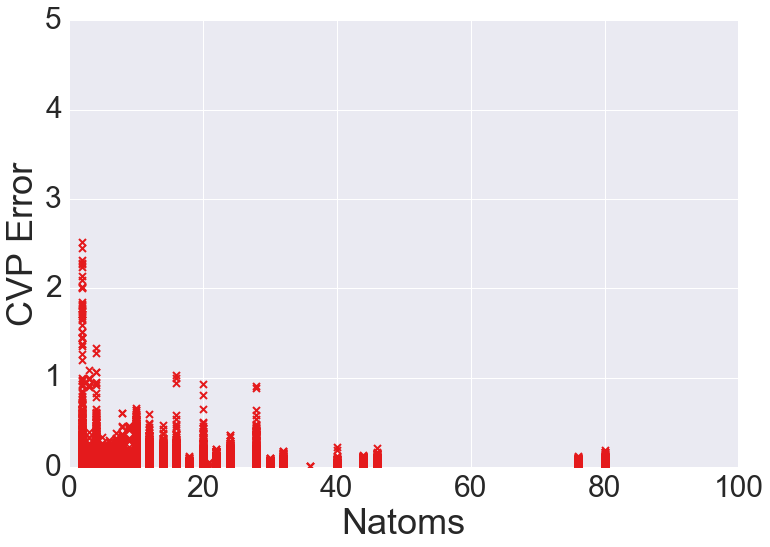

In [27]:
from pymatgen.core import Composition

nprototypes = 100
num_structs = 20

cvp_errors_i, matched_structures_i, vol_data_i = get_cvp_data(all_data, nprototypes, 
                                                        num_structs, is_ionic_radius=True, 
                                                        iso_only=False)

natoms_data = []

for e, m in zip(cvp_errors_i, matched_structures_i):
    s = Structure.from_dict(all_data[m[-1]]["matches"][0]["structure"])
    natoms_data.append([s.num_sites, e])

plot_data(natoms_data, xlim=100, ylim=5, xlabel="Natoms", ylabel="CVP Error")

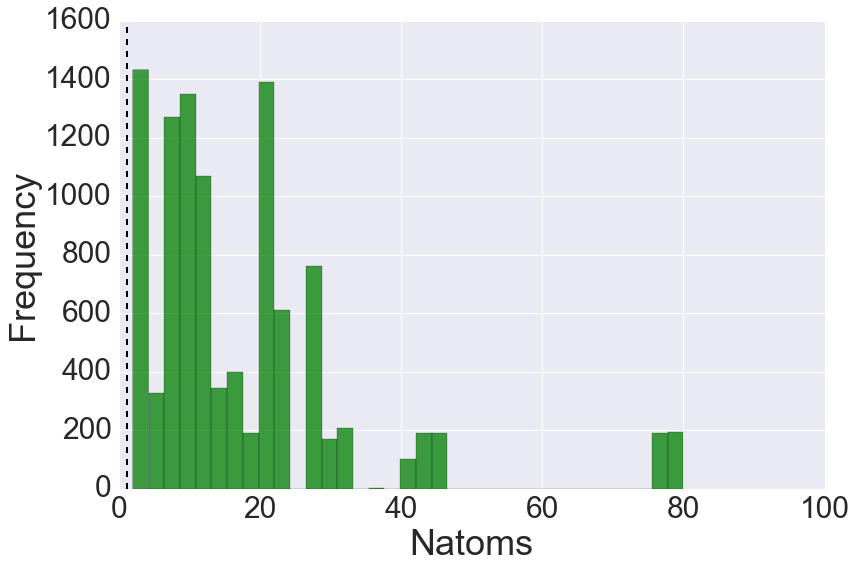

In [33]:
%matplotlib inline

data = [n[0] for n in natoms_data]

plt = get_publication_quality_plot(12,8)
# the histogram of the data
plt.hist(data, 35, facecolor='green', alpha=0.75)
plt.xlabel("Natoms")
plt.ylabel("Frequency")
plt.axvline(x=1.2, ymin=0.0, ymax = 10.0, linewidth=2, color='k', ls="--")
plt.xlim(0, 100)
plt.ylim(0, 1600)
plt.tight_layout()
plt.show()

Done with 10385 CVP predictions.
The length of vol data is 10385.


<module 'matplotlib.pyplot' from '/Users/iekhengchu/.pyenv/versions/3.5.1/lib/python3.5/site-packages/matplotlib/pyplot.py'>

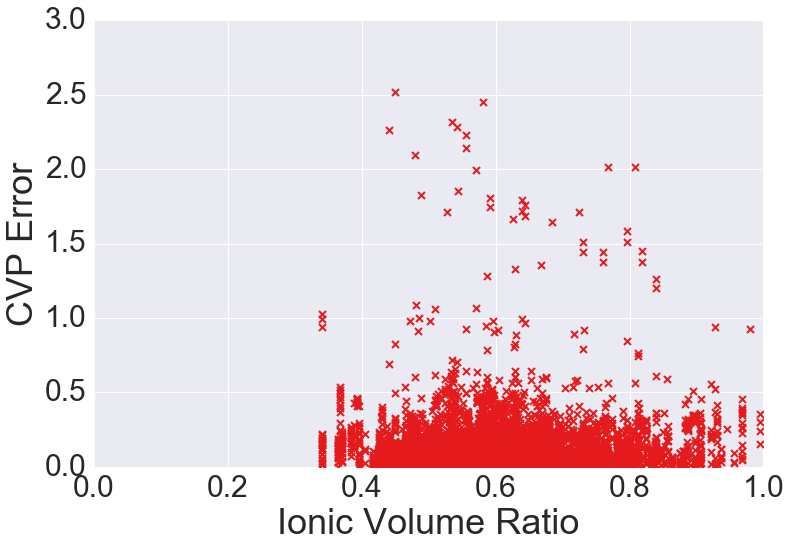

In [20]:
from pymatgen.core import Composition
import numpy as np

nprototypes = 100
num_structs = 20

cvp_errors_i, matched_structures_i, vol_data_i = get_cvp_data(all_data, nprototypes, 
                                                        num_structs, is_ionic_radius=True, 
                                                        iso_only=False)

void_data = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for e, m in zip(cvp_errors_i, matched_structures_i):
        vol_ionic = 4./3. * np.pi * np.sum([v * k.ionic_radius ** 3 
                                            for k, v in m[1].composition.items()])
        
        #Exclude high-pressure compounds
        if vol_ionic / m[1].volume < 1:
            void_data.append([vol_ionic / m[1].volume, e])

plot_data(void_data, xlim=1, ylim=3, xlabel="Ionic Volume Ratio", ylabel="CVP Error")